**Importing Dependencies**

In [62]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import joblib
import re
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


**Data Collection and Cleaning**

In [63]:
# loading the data in a pandsa dataframe
songs = pd.read_csv('C:/Users/USER/Desktop/Datasets/spotify_songdata.csv')
songs.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [64]:
# number of rows and columns 
songs.shape

(57650, 4)

In [65]:
# overview of the dataframe 
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [66]:
# checking for missing values 
songs.isna().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [67]:
# Top artist by number of songs 
top_artists = songs['artist'].value_counts().head(10)
print('\nTop ten Artist')
print(top_artists)


Top ten Artist
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Cher                187
Alabama             187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [68]:
# sample 10,000 rows of the dataset 
songs = songs.sample(10000)

# remove the the link column 
songs = songs.drop('link', axis=1).reset_index()
songs.shape

(10000, 4)

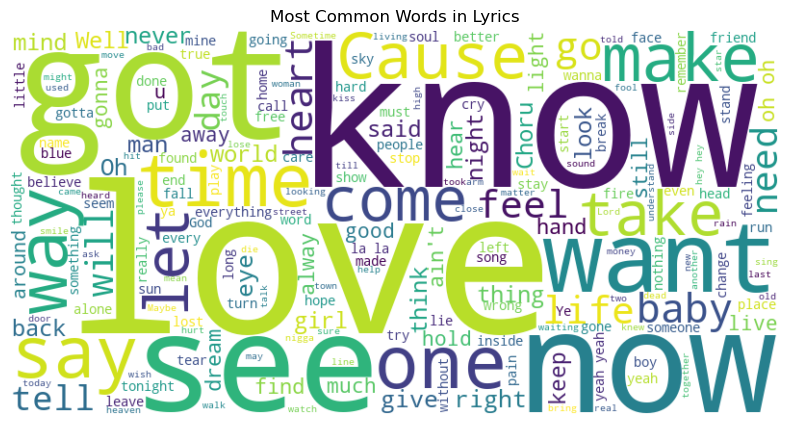

In [69]:
# wordcloud for song lyrics 
all_lyrics = ' '.join(songs['text'].dropna())
wordclound = WordCloud(width=800, height=400, background_color='white', ).generate(all_lyrics)

# visualize the most common words in the lyrics
plt.figure(figsize=(10, 5))
plt.imshow(wordclound, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Lyrics')
plt.show()

**Data Pre-Processing**

In [70]:
# download nltk data 
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [71]:
# reomoving duplicate words
stop_words = set(stopwords.words('english'))

In [72]:
def process_text(text):
    # romove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', "", text)
    #convert to lowercase
    text = text.lower()
    #tokenize and romove stopwords 
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [73]:
# apply preprocessing to lyrics 
songs['cleaned_text'] = songs['text'].apply(process_text)

In [74]:
songs.head()

,index,artist,song,text,cleaned_text
0,3370,Conway Twitty,As Good As A Lonely Girl Can Be,Tell me darling have I been away too long \r\...,tell darling away long wrong leave im coming h...
1,53489,Tom T. Hall,I Feel Like Flying Away,I woke up this morning feeling so good feeling...,woke morning feeling good feeling much better ...
2,15995,Phil Collins,This Love This Heart,"This love, this heart, these arms to hold \r\...",love heart arms hold tight wont let go real dr...
3,9873,Judas Priest,Bullet Train,Sunrise showing every flaw \r\nPaying for the...,sunrise showing every flaw paying night dark e...
4,53278,Tina Turner,Back Where You Started,Baby tell me what you're trying to prove \r\n...,baby tell youre trying prove playing games hea...


In [75]:
# sample a subset of rows(10,000) before vectorizing
sampled_songs = songs.sample(n=10000, random_state=42)

# vectorization(convert text into numerical values)
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer = vectorizer.fit_transform(songs['cleaned_text'])

In [76]:
# cosine similarity 
cosine_sim = cosine_similarity(vectorizer, vectorizer)

In [77]:
# recommendation function
def recommend_songs(song_name, cosine_sim=cosine_sim, dataframe=songs, top_n=10):
    # locate the index of the input song
    idx = dataframe[dataframe['song'].str.lower() == song_name.lower()].index
    
    # handle case where song is not found
    if len(idx) == 0: 
        return 'Song not found in the dataset'

    # get the actual integer index
    idx = idx[0]  

    # get similarity scores between this song and all others
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort by similarity score in descending order
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # get the top_n most similar songs (excluding itself at [0])
    sim_scores = sim_scores[1:top_n + 1]

    # get the indices of the recommended songs
    song_indices = [i[0] for i in sim_scores]

    # return the recommended song titles
    return dataframe['song'].iloc[song_indices]


In [79]:
songs['song'][66]

'Fear Is The Key'

In [81]:
# example of recommendation 
print('\nTop Ten Recommendations')
recommendations = recommend_songs('Fear Is The Key')
print(recommendations)


Top Ten Recommendations
8010         Don't You Remember
740                 Remember Me
7160                      Fever
8614                   Daydream
3314             I Remember You
3862                 Blue Jeans
3844    A Christmas To Remember
3249             I Remember You
1017                      Fever
8949                Remember Me
Name: song, dtype: object


In [82]:
# Save everything
joblib.dump(songs, 'df_cleaned.pkl')

joblib.dump(vectorizer, 'tfidf_matrix.pkl')

joblib.dump(cosine_sim, 'cosine_sim.pkl')

['cosine_sim.pkl']